In [1]:
import jax.numpy as jnp
import jax
import jaxdem as jd
jax.config.update("jax_enable_x64", True)
import numpy as np
import os
from bump_utils import create_clumps
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
from tqdm import tqdm

root = '/home/mmccraw/dev/data/26-01-01/grant/neighbor-list-characterization/dynamics-14/mu-0.4-skin-0.01/'  # 0.01, 0.001
# root = '/home/mmccraw/dev/data/26-01-01/grant/neighbor-list-characterization/dynamics-11/mu-0.1-skin-0.5/'
# root = '/home/mmccraw/dev/data/26-01-01/grant/neighbor-list-characterization/dynamics-10/mu-1.0-skin-0.01/'
# root = '/home/mmccraw/dev/data/26-01-01/grant/neighbor-list-characterization/dynamics-7/mu-1.0-skin-0.01/'
# root = '/home/mmccraw/dev/data/26-01-01/grant/neighbor-list-characterization/dynamics-7/mu-0.01-skin-0.5/'

traj_state = jd.utils.h5.load(os.path.join(root, 'state.h5'))
traj_system = jd.utils.h5.load(os.path.join(root, 'system.h5'))

pe = jax.vmap(jd.utils.thermal.compute_potential_energy)(traj_state, traj_system)
ke_t = jax.vmap(jd.utils.thermal.compute_translational_kinetic_energy)(traj_state)
ke_r = jax.vmap(jd.utils.thermal.compute_rotational_kinetic_energy)(traj_state)
te = pe + ke_r + ke_t

imbalances = []
for i in range(traj_state.shape[0]):
    f = traj_state.force[i]
    cid = traj_state.clump_ID[i]
    order = jnp.argsort(traj_state.unique_ID[i])
    _, offsets = jnp.unique(traj_state.clump_ID[i][order], return_index=True)
    imbalances.append(jnp.linalg.norm(jnp.sum(f[order][offsets], axis=0)))
imbalances = jnp.array(imbalances)

W0124 15:27:02.144444 1240624 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0124 15:27:02.146280 1239035 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [2]:
def force(i, j, pos, rad, bs, k):
    R = rad[i] + rad[j]
    rij = pos[i] - pos[j]
    rij -= bs * jnp.round(rij / bs)
    r = jnp.sum(rij**2, axis=-1)
    r = jnp.where(r == 0, 1.0, jnp.sqrt(r))
    s = R / r - 1.0
    s *= s > 0
    return (k * s)[..., None] * rij

def compute_forces(pos, rad, bs, nl, state, system):
    iota = jax.lax.iota(dtype=int, size=state.N)
    def per_particle_force(i, neighbors):
        def per_neighbor_force(j_id):
            valid = j_id != -1
            safe_j = jnp.maximum(j_id, 0)
            f = force(i, safe_j, pos, rad, bs, k=1)
            return f * valid
        forces = jax.vmap(per_neighbor_force)(neighbors)
        f_sum = jnp.sum(forces, axis=0)
        return f_sum
    return jax.vmap(per_particle_force)(iota, nl)

def draw(st, sy, j, ax=None, cell_alpha=0.2):
    if ax is None:
        ax = plt.gca()

    bs = sy.domain.box_size[j]
    pos = jnp.mod(st.pos[j], bs)
    rad = st.rad[j]
    nl = sy.collider.neighbor_list[j]
    f = compute_forces(
        pos,
        rad,
        bs,
        nl,
        st,
        sy,
    )

    cs = sy.collider.cell_list.cell_size[j]
    iteration = 0
    while True:
        if jnp.all(cs * iteration > bs):
            break
        ax.axvline(cs * iteration, c='k', alpha=cell_alpha, zorder=0)
        ax.axhline(cs * iteration, c='k', alpha=cell_alpha, zorder=0)
        iteration += 1

    ax.set_aspect('equal')
    ax.set_xlim(0, bs[0])
    ax.set_ylim(0, bs[1])
    for p, r in tqdm(zip(pos, rad), total=len(rad)):
        ax.add_patch(Circle(p, r))
    fp = f / jnp.linalg.norm(f, axis=-1, keepdims=True)
    ax.quiver(pos[:, 0], pos[:, 1], fp[:, 0], fp[:, 1])
    # ax.quiver(pos[:, 0], pos[:, 1], f[:, 0], f[:, 1])
    return f

def draw_neighbors(i, uuid, state, system, ax, scale=1.0, nc='r'):
    pos = state.pos[i]
    rad = state.rad[i]
    nl = system.collider.neighbor_list[i]
    ax.add_patch(Circle(pos[uuid], rad[uuid], facecolor='k'))
    for nuuid in nl[uuid]:
        if nuuid == -1:
            break
        ax.add_patch(Circle(pos[nuuid], rad[nuuid] * scale, facecolor=nc))

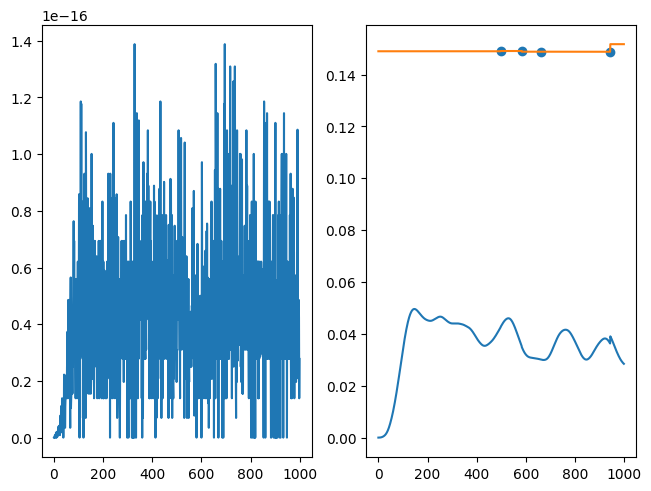

In [3]:
fig, ax = plt.subplots(1, 2, constrained_layout=True)
ax[0].plot(imbalances)
ax[1].plot(pe)
ax[1].plot(te)
# ax[1].plot(np.diff(traj_system.collider.n_build_times) * np.max(te), zorder=0)
bad_indices = np.argwhere(np.abs(np.diff(te)) > 1e-6).flatten()
ax[1].scatter(bad_indices, te[bad_indices])

In [4]:
traj_system.collider.n_build_times[i]

Array(500, dtype=int64)

100%|██████████| 1300/1300 [00:02<00:00, 527.45it/s]


Text(0.5, 1.0, 'First Bad Step')

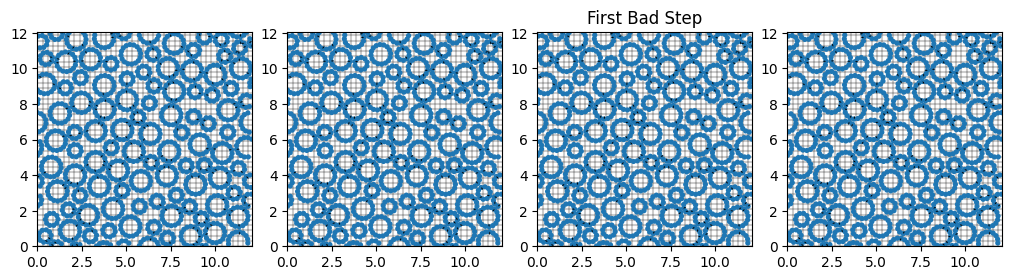

In [5]:
i = bad_indices[0] + 1
i_prev = i - 1
i_next = i + 1

fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(10, 5))
f_prev_prev = draw(traj_state, traj_system, i - 2, ax[0])
f_prev = draw(traj_state, traj_system, i - 1, ax[1])
f = draw(traj_state, traj_system, i, ax[2])
f_next = draw(traj_state, traj_system, i + 1, ax[3])
ax[2].set_title('First Bad Step')

# order = jnp.argsort(traj_state.unique_ID[i])
# order_prev = jnp.argsort(traj_state.unique_ID[i_prev])
# diff_ids = jnp.argwhere((jnp.linalg.norm(f[order], axis=-1) > 0) != (jnp.linalg.norm(f_prev[order_prev], axis=-1) > 0)).flatten()
# for uid in diff_ids:
#     uuid = int(jnp.argwhere(traj_state.unique_ID[i] == uid)[0][0])
#     uuid_prev = int(jnp.argwhere(traj_state.unique_ID[i_prev] == uid)[0][0])
#     draw_neighbors(i_prev, uuid_prev, traj_state, traj_system, ax[0], scale=0.5)
#     draw_neighbors(i, uuid, traj_state, traj_system, ax[1], scale=0.5)
# plt.savefig('example.png', dpi=600)

In [10]:
nl

Array([[113, 120, 121, ...,  -1,  -1,  -1],
       [113, 120, 121, ...,  -1,  -1,  -1],
       [113, 124, 125, ...,  -1,  -1,  -1],
       ...,
       [  4,   5,   6, ...,  -1,  -1,  -1],
       [  3,   4,   5, ...,  -1,  -1,  -1],
       [  0,   1,   2, ...,  -1,  -1,  -1]], dtype=int64)

In [8]:
k = i - 1

pos = traj_state.pos[k]
clump_ID = traj_state.clump_ID[k]
bs = traj_system.domain.box_size[k]
nl_rad = float((traj_system.collider.cutoff + traj_system.collider.skin)[k])
nl = traj_system.collider.neighbor_list[k]
dr = pos[:, None, :] - pos[None, :, :]
dr -= bs * jnp.round(dr / bs)
dr = jnp.linalg.norm(dr, axis=-1)
id_i, id_j = jnp.triu_indices_from(dr, k=1)
clump_mask = clump_ID[id_i] != clump_ID[id_j]
valid_dr = dr[id_i, id_j][clump_mask]
id_i = id_i[clump_mask][valid_dr <= nl_rad]
id_j = id_j[clump_mask][valid_dr <= nl_rad]

nl_id_i, nl_id_j = [], []
for nl_i, _nl in enumerate(nl):
    for nl_j in _nl:
        if nl_j == -1:
            break
        nl_id_i.append(nl_i)
        nl_id_j.append(nl_j)
nl_id_i = jnp.array(nl_id_i)
nl_id_j = jnp.array(nl_id_j)

nl_ids = jnp.column_stack((nl_id_i, nl_id_j))
missing_ids = []
for ids in jnp.column_stack((id_i, id_j)):
    if not jnp.any(jnp.all(nl_ids == ids, axis=-1)):
        print(f'Missing pairs {ids}')
        missing_ids.append(ids)

Missing pairs [269 272]
Missing pairs [851 853]
Missing pairs [1292 1293]


In [16]:
for missing_i, missing_j in missing_ids:
    dr = pos[missing_i] - pos[missing_j]
    dr -= bs * jnp.round(dr / bs)
    r = jnp.linalg.norm(dr, axis=-1)
    print(r, nl_rad)

0.2939933110759123 0.29409250568518436
0.2690847349625065 0.29409250568518436


In [63]:
traj_state.rad[i][0] * 2

Array(0.29379871, dtype=float64)

In [34]:
traj_state.N

245

In [5]:
traj_system.collider.neighbor_list[i_prev][uuid_prev]

Array([47, 55, 56, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

In [19]:
jnp.max(jnp.sum(traj_system.collider.neighbor_list != -1, axis=-1))

Array(2, dtype=int64)